<a href="https://colab.research.google.com/github/yevintheenura01/DL_Assignment/blob/Yevin/EnsembleModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# -------------------------------
# 1️⃣ Import libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)
import joblib

In [12]:
# -------------------------------
# 2️⃣ Load processed data
# -------------------------------
from google.colab import drive
drive.mount('/content/drive')

train_df = pd.read_csv("/content/drive/MyDrive/DiabetesPrediction/outputs/clean_data_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/DiabetesPrediction/outputs/clean_data_test.csv")

X_train = train_df.drop('diabetes', axis=1).values
y_train = train_df['diabetes'].values
X_test = test_df.drop('diabetes', axis=1).values
y_test = test_df['diabetes'].values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# For CNN and LSTM, we need 3D input [samples, timesteps, features]
X_train_r = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_r  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [14]:
print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (140262, 8)
Testing shape: (35066, 8)


In [18]:
# -----------------------------------------------
# 2️⃣ Define Helper Function for Evaluation
# -----------------------------------------------
def evaluate_model(model, X_test, y_test, model_name):
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    print(f"\n📊 Results for {model_name}")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {acc:.4f}, Precision: {pre:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC-AUC: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_pred_prob)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()

    return acc, pre, rec, f1, auc

In [19]:
# -----------------------------------------------
# 3️⃣ Define Deep Learning Models
# -----------------------------------------------

# 🔹 Artificial Neural Network (ANN)
def build_ann():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [20]:
# 🔹 1D Convolutional Neural Network (CNN)
def build_cnn():
    inputs = Input(shape=(X_train.shape[1], 1))
    x = Conv1D(64, 2, activation='relu')(inputs)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [21]:
# 🔹 LSTM Model
def build_lstm():
    inputs = Input(shape=(X_train.shape[1], 1))
    x = LSTM(64, return_sequences=False)(inputs)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
# -----------------------------------------------
# 4️⃣ Train Models
# -----------------------------------------------
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

ann = build_ann()
cnn = build_cnn()
lstm = build_lstm()

history_ann = ann.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=64, callbacks=[es], verbose=1)
history_cnn = cnn.fit(X_train_r, y_train, validation_split=0.2, epochs=30, batch_size=64, callbacks=[es], verbose=1)
history_lstm = lstm.fit(X_train_r, y_train, validation_split=0.2, epochs=30, batch_size=64, callbacks=[es], verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8762 - loss: 0.2718 - val_accuracy: 0.9026 - val_loss: 0.2027
Epoch 2/30
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9034 - loss: 0.2024 - val_accuracy: 0.9112 - val_loss: 0.1872
Epoch 3/30
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9099 - loss: 0.1875 - val_accuracy: 0.9124 - val_loss: 0.1815
Epoch 4/30
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9116 - loss: 0.1835 - val_accuracy: 0.9133 - val_loss: 0.1800
Epoch 5/30
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9126 - loss: 0.1815 - val_accuracy: 0.9136 - val_loss: 0.1782
Epoch 6/30
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9125 - loss: 0.1807 - val_accuracy: 0.9145 - val_loss: 0.1761
Epoch 7/30
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9134 - loss: 0.1779 - val_accuracy: 0.9150 - val_loss: 0.1759
Epoch 8/30
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9137 - loss: 0.1773 -

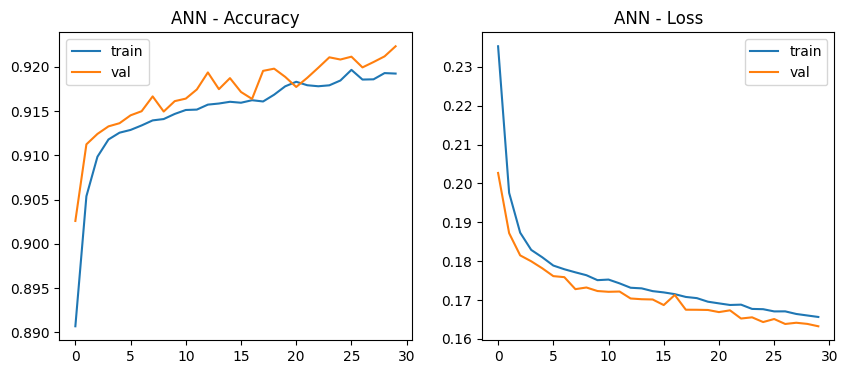

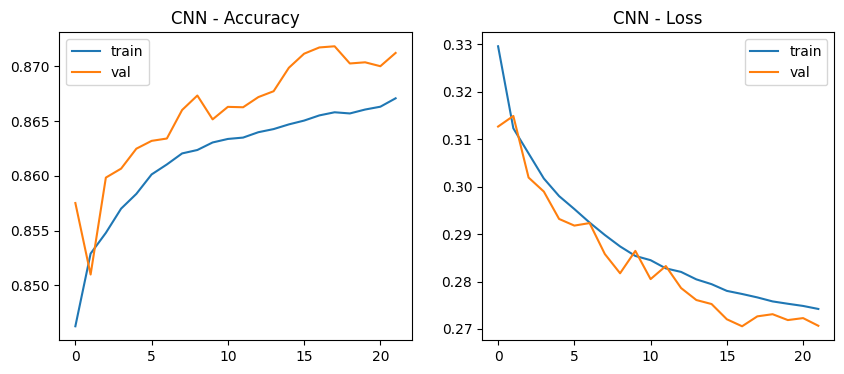

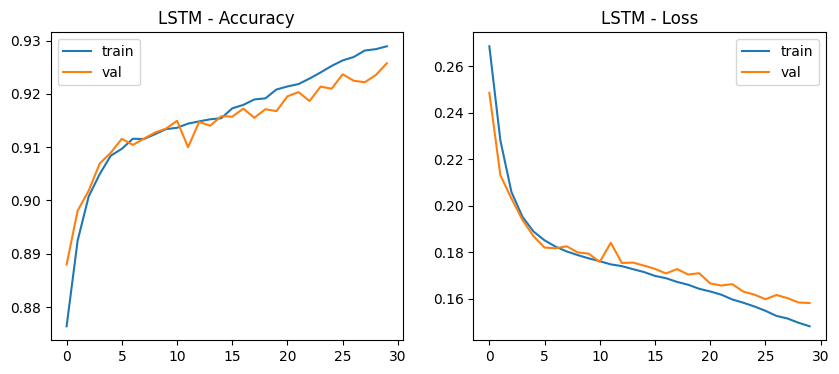

In [23]:
# -----------------------------------------------
# 5️⃣ Plot Accuracy and Loss Curves
# -----------------------------------------------
def plot_history(history, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

plot_history(history_ann, "ANN")
plot_history(history_cnn, "CNN")
plot_history(history_lstm, "LSTM")

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

📊 Results for ANN
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     17533
           1       0.90      0.94      0.92     17533

    accuracy                           0.92     35066
   macro avg       0.92      0.92      0.92     35066
weighted avg       0.92      0.92      0.92     35066

Accuracy: 0.9186, Precision: 0.8994, Recall: 0.9426, F1: 0.9205, ROC-AUC: 0.9817


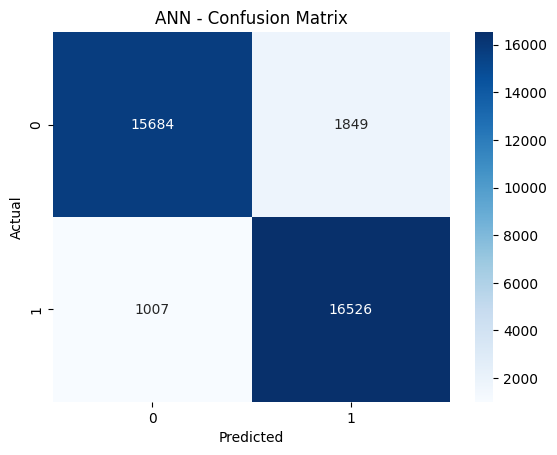

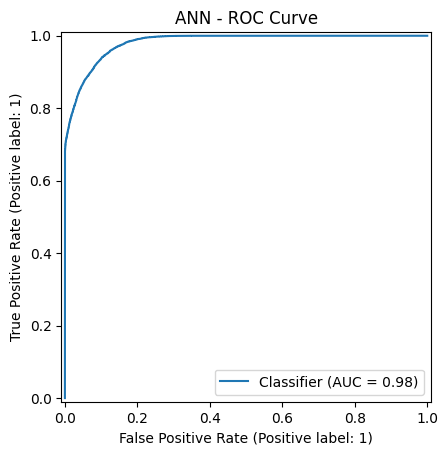

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

📊 Results for CNN
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     17533
           1       0.84      0.89      0.87     17533

    accuracy                           0.86     35066
   macro avg       0.87      0.86      0.86     35066
weighted avg       0.87      0.86      0.86     35066

Accuracy: 0.8642, Precision: 0.8448, Recall: 0.8923, F1: 0.8679, ROC-AUC: 0.9503


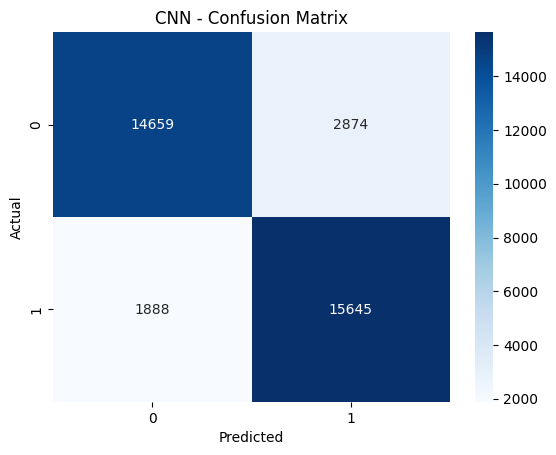

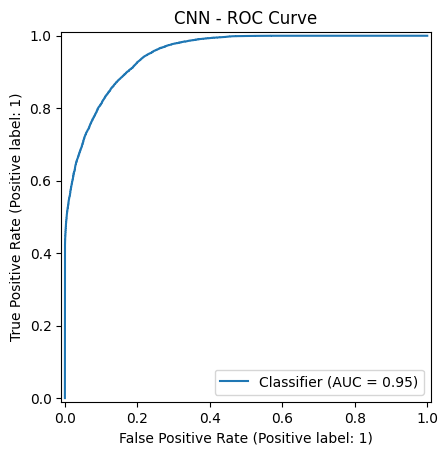

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

📊 Results for LSTM
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     17533
           1       0.90      0.95      0.93     17533

    accuracy                           0.92     35066
   macro avg       0.92      0.92      0.92     35066
weighted avg       0.92      0.92      0.92     35066

Accuracy: 0.9229, Precision: 0.8993, Recall: 0.9524, F1: 0.9251, ROC-AUC: 0.9832


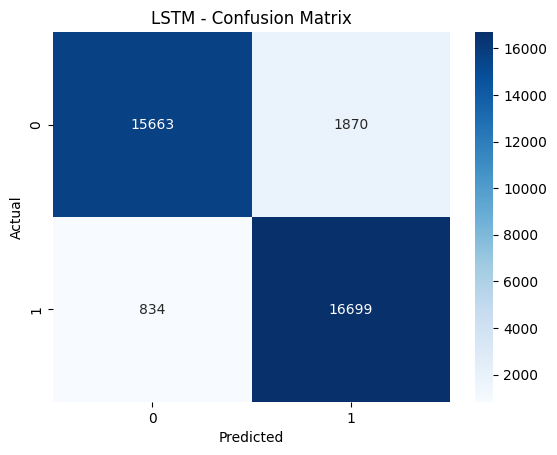

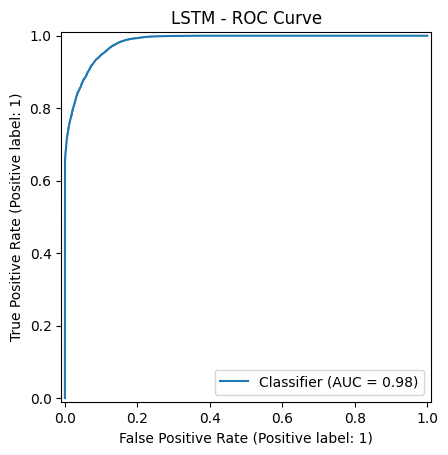

In [24]:
# -----------------------------------------------
# 6️⃣ Evaluate Each Model
# -----------------------------------------------
results = {}
results["ANN"] = evaluate_model(ann, X_test, y_test, "ANN")
results["CNN"] = evaluate_model(cnn, X_test_r, y_test, "CNN")
results["LSTM"] = evaluate_model(lstm, X_test_r, y_test, "LSTM")


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

💪 Deep Ensemble Model Performance:
Accuracy: 0.9203, Precision: 0.8994, Recall: 0.9465, F1: 0.9224, ROC-AUC: 0.9815


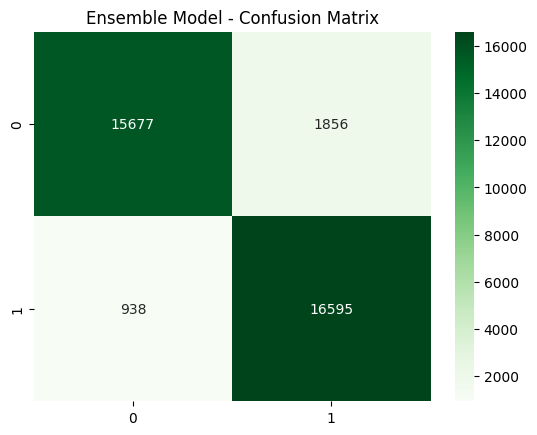

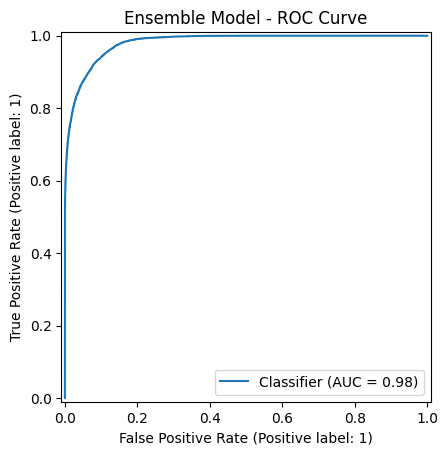

In [25]:
# -----------------------------------------------
# 7️⃣ Build Deep Ensemble Model (Average Voting)
# -----------------------------------------------
pred_ann = ann.predict(X_test)
pred_cnn = cnn.predict(X_test_r)
pred_lstm = lstm.predict(X_test_r)

# Average predictions
ensemble_pred_prob = (pred_ann + pred_cnn + pred_lstm) / 3
ensemble_pred = (ensemble_pred_prob > 0.5).astype(int)

# Evaluate Ensemble
acc = accuracy_score(y_test, ensemble_pred)
pre = precision_score(y_test, ensemble_pred)
rec = recall_score(y_test, ensemble_pred)
f1 = f1_score(y_test, ensemble_pred)
auc = roc_auc_score(y_test, ensemble_pred_prob)

print("\n💪 Deep Ensemble Model Performance:")
print(f"Accuracy: {acc:.4f}, Precision: {pre:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC-AUC: {auc:.4f}")

cm = confusion_matrix(y_test, ensemble_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Ensemble Model - Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, ensemble_pred_prob)
plt.title("Ensemble Model - ROC Curve")
plt.show()

results["Ensemble"] = (acc, pre, rec, f1, auc)



📈 Model Performance Summary:


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
ANN,0.918554,0.899374,0.942565,0.920463,0.981653
CNN,0.864199,0.844808,0.892317,0.867913,0.950300
LSTM,0.922888,0.899295,0.952433,0.925101,0.983195
Ensemble,0.920322,0.899409,0.946501,0.922354,0.981500


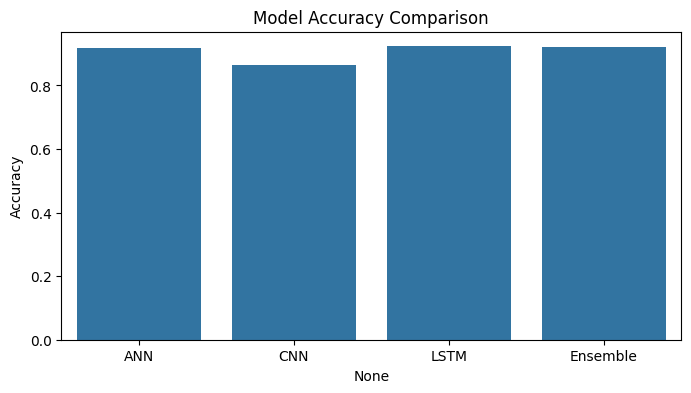

In [27]:
# -----------------------------------------------
# 8️⃣ Summary Table of Results
# -----------------------------------------------
summary_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]).T
print("\n📈 Model Performance Summary:")
display(summary_df)

plt.figure(figsize=(8,4))
sns.barplot(x=summary_df.index, y=summary_df["Accuracy"])
plt.title("Model Accuracy Comparison")
plt.show()

In [7]:
# -------------------------------
# 3️⃣ Load saved scaler and encoder (optional)
# -------------------------------
scaler = joblib.load("/content/drive/MyDrive/DiabetesPrediction/outputs/scaler.pkl")
# encoder = joblib.load("/content/drive/MyDrive/DiabetesPrediction/outputs/encoder.pkl") # Uncomment if you need to load an encoder

In [9]:
# -------------------------------
# 4️⃣ Handle class imbalance
# -------------------------------
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}

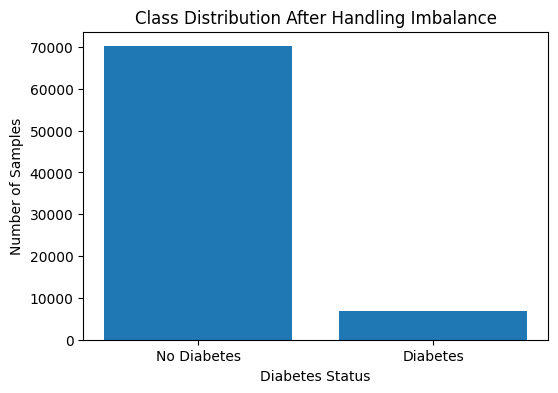

In [10]:
# -------------------------------
# 5️⃣ Visualize class distribution after handling imbalance
# -------------------------------
import matplotlib.pyplot as plt

class_counts = pd.Series(y_train).value_counts()

plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values)
plt.xticks(class_counts.index, ['No Diabetes', 'Diabetes'])
plt.xlabel('Diabetes Status')
plt.ylabel('Number of Samples')
plt.title('Class Distribution After Handling Imbalance')
plt.show()